In [ ]:
!pip install gymnasium

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
import torch
import numpy as np
from agent import QLearningAgent,DQNAgent,REINFORCE,ActorCritic,A2C
import cv2
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard
import wandb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
observation, info = env.reset(seed=42)

def show_env(env):
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

def plot(x,ylabel='Loss'):
    # === Plot ===
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(range(len(x)), x)
    plt.show()

def test_agent(agent, env="LunarLander-v3", num_envs=8, num_episodes=1000):
    """
    并行测试智能体在多个环境中的表现，不进行学习和探索。
    输入:
        agent: 智能体对象，需实现 get_action 方法
        num_envs: 并行环境数量
        num_episodes: 总测试回合数
    输出:
        绘制奖励分布图
        """
        # 这里必须是工厂函数列表
    envs =  gym.make_vec(env, num_envs=num_envs, vectorization_mode="sync") # 同步环境
    total_rewards = []
    episodes_per_env = num_episodes // num_envs
    agent.eval()

    for _ in range(episodes_per_env):
        states, infos = envs.reset()
        dones = [False] * num_envs
        rewards = [0.0] * num_envs

        while not all(dones):
            actions, _ = agent.get_action(states)
            next_states, step_rewards, terminated, truncated, infos = envs.step(actions)
            for i in range(num_envs):
                if not dones[i]:
                    rewards[i] += step_rewards[i]
                    dones[i] = terminated[i] or truncated[i]
            states = next_states
        total_rewards.extend(rewards)

    plt.figure(figsize=(8,5))
    plt.hist(total_rewards, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('reward')
    plt.ylabel('episodes')
    plt.title(f'{num_episodes} episodes-reward distribution')
    plt.show()
    
def save_video(agent, env, file_name):
    frames = []
    obs, infos = env.reset()
    sum_reward = 0
    agent.eval()
    while True:
        action, prob = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        obs = next_obs
        sum_reward += reward

        frame = env.render()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.putText(frame, f"Reward: {sum_reward:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 0), 2, cv2.LINE_AA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

        if terminated or truncated:
            break

    # 保存为视频
    imageio.mimsave(file_name, frames, fps=30)
    Video(file_name, embed=True)

In [ ]:
print('动作空间：', env.action_space)
print('观察空间: ', env.observation_space) # 8个值的区间
# 观察就是部分状态

In [ ]:
frames = []

while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if terminated or truncated:
        break

# 保存为视频
imageio.mimsave('lunarlander.mp4', frames, fps=30)
Video('lunarlander.mp4', embed=True)

In [ ]:
agent = QLearningAgent(
        state_size=8,
        action_size=2,
        device=device)
agent.qnet.to(device)  # 模型转到GPU

episodes = 1000
loss_history = []

for episode in range(episodes):
    state, info = env.reset()
    total_loss, cnt = 0, 0
    terminated = False
    truncated = False
    t = 0

    while not (terminated or truncated):
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        loss = agent.update(state, action, reward, next_state, terminated or truncated)
        state = next_state
        t += 1
    agent.epsilon_update()

    writer.add_scalar('Loss/train', loss, episode)
    writer.add_scalar('Reward/train', reward, episode)
    writer.add_scalar('Episode Duration/train', t, episode)
    writer.add_scalar('Epl/train', t, episode)

In [ ]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

In [ ]:
# 保存权重
torch.save(agent.qnet.state_dict(), "lunar_lander.pth")

In [ ]:
agent = DQNAgent(
    lr=0.0001,
    epsilon=1,
    epsilon_decay=0.995,
    TAU=0.005,
    batch_size=128,
    buffer_size=10000,
    action_size=4,
    device=device,
    use_cnn=False
    )

In [ ]:

agent.train()
writer = SummaryWriter()
episodes = 600

for episode in range(episodes):
    state, info = env.reset()
    done = False
    t = 0
    total_reward = 0
    while not done:
        action, Q = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        loss = agent.update(state, action, reward, next_state, done)
        t += 1
        state = next_state
        total_reward += reward

    agent.epsilon_update()
    writer.add_scalar('Loss/train', loss, episode)
    writer.add_scalar('Reward/train', total_reward, episode)
    writer.add_scalar('Episode Duration/train', t, episode)
    writer.add_scalar('Epsilon/train', agent.epsilon, episode)

writer.close()

In [ ]:
agent.save("models/dqn_lunar_lander.pth")

In [ ]:
agent.load("models/dqn_lunar_lander.pth")

In [ ]:
test_agent(agent,env="LunarLander-v3",num_envs=128,num_episodes=1000)

In [ ]:
save_video(agent, env,'dqn_lunarlander.mp4')

In [ ]:
agent = REINFORCE(
    lr=0.001,
    action_size=4)
episodes=5000

In [ ]:
for episode in range(episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    sum_reward = 0

    while not (terminated or truncated): 
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action.item())

        agent.add(reward, prob)
        state = next_state
        sum_reward += reward

    loss = agent.update()

    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}, loss : {:.4f}".format(episode, sum_reward, loss))

In [ ]:
torch.save(agent.pi.state_dict(), "models/reinforce_lunar_lander2.pth")

In [ ]:
agent.pi.load_state_dict(torch.load("models/reinforce_lunar_lander2.pth"))

In [ ]:
test_agent(agent,env="LunarLander-v3",num_envs=128,num_episodes=1000)

In [ ]:
save_video(agent, env)

In [ ]:
hyperparams = {
    'lr_pi': 0.001,
    'lr_v': 0.0002,
    'gamma': 0.98
}
agent = ActorCritic(
    action_size=4,
    device='cpu',
    **hyperparams
)
# agent.train()
writer = SummaryWriter(comment="ActorCritic")
writer.add_hparams(hyperparams, {})
episodes = 600

for episode in range(episodes):
    state, info = env.reset()
    done = False
    t = 0
    actor_loss = 0
    critic_loss = 0
    total_reward = 0

    while not done: 
        action, action_probs = agent.get_action(state)
        next_state, reward,  terminated, truncated, info = env.step(action)
        
        done = (terminated or truncated)
        losses = agent.update(state, action, action_probs, reward, next_state, done)
        state = next_state
        actor_loss += losses['actor_loss']
        critic_loss += losses['critic_loss']
        total_reward += reward
        t += 1

    writer.add_scalar('Actor Loss/train', actor_loss, episode)
    writer.add_scalar('Critic Loss/train', critic_loss, episode)
    writer.add_scalar('Reward/train', total_reward, episode)
    writer.add_scalar('Episode Duration/train', t, episode)

writer.close()

In [3]:
config = {
    'agent': 'A2C',
    'action_size': 4,
    'device': device,
    'lr_pi': 0.0002,
    'lr_v': 0.0005,
    'gamma': 0.99,
    'episodes': 600,
    'total_steps': 50_000,
    'num_env': 128
}
agent = A2C(
    **config
)

In [4]:
wandb.init(
    project="LunarLander-v3",
    config=config,  # 直接传入你的 config 字典
    name="A2C训练"
)

env_vec = gym.make_vec("LunarLander-v3", num_envs=config['num_env'], vectorization_mode="sync") # 同步环境向量，会打开autoreset模式
states, infos = env_vec.reset()
actor_loss = 0
critic_loss = 0
total_reward = 0

for step in range(config['total_steps']):
    actions, action_probs = agent.get_action(states)
    next_states, rewards, terminated, truncated, info = env_vec.step(actions)

    done = np.logical_or(terminated, truncated)
    losses = agent.update(states, actions, action_probs, rewards, next_states, done)
    
    states = next_states
    actor_loss += losses['actor_loss']
    critic_loss += losses['critic_loss']
    total_reward += np.mean(rewards)

    if step % 600 == 0:
        wandb.log({
            'Actor Loss/train': actor_loss,
            'Critic Loss/train': critic_loss,
            'Reward/train': total_reward,
        }, step=step)
        actor_loss = 0
        critic_loss = 0
        total_reward = 0

wandb.finish()

wandb: Currently logged in as: 1358467720 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Actor Loss/train,█▁▆▇█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███████████████
Critic Loss/train,█▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▂▂▂
Reward/train,▁█▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▆▇▇▇██▇▇▇▇█▇
Actor Loss/train,-6506.31302
Critic Loss/train,4830.01322
Reward/train,-11.20223


In [5]:
episodes = config['episodes']
env_vec = gym.make_vec("LunarLander-v3", num_envs=config['num_env'], vectorization_mode="sync") # 同步环境向量

writer = SummaryWriter(comment="A2C")
for episode in range(episodes):
    states, info = env_vec.reset()
    done = np.array([False])
    t = 0
    actor_loss = 0
    critic_loss = 0
    total_reward = 0

    while not done.all(): 
        actions, action_probs = agent.get_action(states)
        next_states, rewards, terminated, truncated, info = env_vec.step(actions)

        done = np.logical_or(terminated, truncated)
        losses = agent.update(states, actions, action_probs, rewards, next_states, done)
        
        states = next_states
        actor_loss += losses['actor_loss']
        critic_loss += losses['critic_loss']
        total_reward += np.mean(rewards)
        t += 1
        if t > 600: # 感觉有问题，如果不设置就会无限等待下去
            break


    writer.add_scalar('Actor Loss/train', actor_loss, episode)
    writer.add_scalar('Critic Loss/train', critic_loss, episode)
    writer.add_scalar('Reward/train', total_reward, episode)
    writer.add_scalar('Episode Duration/train', t, episode)

In [23]:
from stable_baselines3 import A2C
env = gym.make("LunarLander-v3", render_mode="RGB_array")
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=2_000_000,progress_bar=True)

d:\conda_env\hf_course\lib\site-packages\gymnasium\envs\registration.py:736: UserWarning: WARN: The environment is 
being initialised with render_mode='RGB_array' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(

Using cuda device

Wrapping the env with a `Monitor` wrapper

Wrapping the env in a DummyVecEnv.

d:\conda_env\hf_course\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are 
trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are 
using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 
for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model
will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 115      |
|    ep_rew_mean        | -434     |
| time/                 |          |
|    fps                | 272      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.21    |
|    explained_variance | -0.026   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -6.62    |
|    value_loss         | 68.8     |
------------------------------------

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 117      |
|    ep_rew_mean        | -469     |
| time/                 |          |
|    fps                | 282      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.973   |
|    explained_variance | -0.042   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -2.17    |
|    value_loss         | 5.74     |
------------------------------------

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 121      |
|    ep_rew_mean        | -468     |
| time/                 |          |
|    fps                | 285      |
|    iterations         | 300      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -1.14    |
|    explained_variance | -0.00283 |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | -5.72    |
|    value_loss         | 20.9     |
------------------------------------

KeyboardInterrupt: 

In [ ]:
vec_env = model.get_env()
obs = vec_env.reset()
rewards = []
for episode in range(100):
    total_rewards = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        total_rewards += reward
        if done:
            rewards.append(total_rewards)
            print(f"Episode finished. Total reward: {total_rewards}")
            break
        # VecEnv resets automatically
        # if done:
        #   obs = env.reset()
print(f"Average reward over 100 episodes: {np.mean(rewards)}")

Episode finished. Total reward: [-68.28235]

Episode finished. Total reward: [-40.361637]

Episode finished. Total reward: [254.73499]

Episode finished. Total reward: [-77.63341]

Episode finished. Total reward: [169.15138]

Episode finished. Total reward: [233.51445]

Episode finished. Total reward: [-35.95395]

Episode finished. Total reward: [175.46959]

Episode finished. Total reward: [229.49904]

Episode finished. Total reward: [-48.349953]

Episode finished. Total reward: [-28.408524]

Episode finished. Total reward: [-46.38932]

Episode finished. Total reward: [227.71425]

Episode finished. Total reward: [-82.64441]

Episode finished. Total reward: [212.16476]

Episode finished. Total reward: [165.9693]

Episode finished. Total reward: [-75.64757]

Episode finished. Total reward: [123.15522]

Episode finished. Total reward: [-69.54472]

Episode finished. Total reward: [-44.484974]

Episode finished. Total reward: [-17.78482]

Episode finished. Total reward: [142.69821]

Episode finished. Total reward: [-86.08979]

Episode finished. Total reward: [-73.95849]

Episode finished. Total reward: [-105.27391]

Episode finished. Total reward: [-46.176125]

Episode finished. Total reward: [-36.077656]

Episode finished. Total reward: [215.9607]

Episode finished. Total reward: [-42.37643]

Episode finished. Total reward: [233.83452]

Episode finished. Total reward: [-41.379204]

Episode finished. Total reward: [191.9602]

Episode finished. Total reward: [257.8693]

Episode finished. Total reward: [229.10149]

Episode finished. Total reward: [-59.49829]

Episode finished. Total reward: [192.58232]

Episode finished. Total reward: [-11.711914]

Episode finished. Total reward: [-81.30591]

Episode finished. Total reward: [-29.553017]

Episode finished. Total reward: [153.19763]

Episode finished. Total reward: [-27.027763]

Episode finished. Total reward: [-42.15857]

Episode finished. Total reward: [137.43661]

Episode finished. Total reward: [-26.223366]

Episode finished. Total reward: [216.72174]

Episode finished. Total reward: [-61.021954]

Episode finished. Total reward: [242.01245]

Episode finished. Total reward: [262.63263]

Episode finished. Total reward: [111.588005]

Episode finished. Total reward: [-47.863625]

Episode finished. Total reward: [214.99332]

Episode finished. Total reward: [-57.606842]

Episode finished. Total reward: [163.13127]

Episode finished. Total reward: [197.11812]

Episode finished. Total reward: [-73.61808]

Episode finished. Total reward: [226.00572]

Episode finished. Total reward: [-35.65335]

Episode finished. Total reward: [177.45401]

Episode finished. Total reward: [-62.792324]

Episode finished. Total reward: [-59.70017]

Episode finished. Total reward: [-106.58348]

Episode finished. Total reward: [-17.384712]

Episode finished. Total reward: [-62.248142]

Episode finished. Total reward: [192.91376]

Episode finished. Total reward: [147.61598]

Episode finished. Total reward: [-100.1338]

Episode finished. Total reward: [-68.87506]

Episode finished. Total reward: [211.56439]

Episode finished. Total reward: [-61.809967]

Episode finished. Total reward: [-52.863777]

Episode finished. Total reward: [205.2088]

Episode finished. Total reward: [223.01935]

Episode finished. Total reward: [-19.544006]

Episode finished. Total reward: [-34.436234]

Episode finished. Total reward: [0.29566956]

Episode finished. Total reward: [-8.361038]

Episode finished. Total reward: [216.37097]

Episode finished. Total reward: [220.59639]

Episode finished. Total reward: [253.24619]

Episode finished. Total reward: [-68.44646]

Episode finished. Total reward: [-58.41895]

Episode finished. Total reward: [-70.30022]

Episode finished. Total reward: [-65.779366]

Episode finished. Total reward: [187.96967]

Episode finished. Total reward: [221.5003]

Episode finished. Total reward: [-62.205257]

Episode finished. Total reward: [-96.7775]

Episode finished. Total reward: [-52.77932]

Episode finished. Total reward: [208.1845]

Episode finished. Total reward: [268.00424]

Episode finished. Total reward: [-63.0477]

Episode finished. Total reward: [164.34593]

Episode finished. Total reward: [174.7286]

Episode finished. Total reward: [-26.220024]

Episode finished. Total reward: [-54.282497]

Episode finished. Total reward: [-67.33652]

Episode finished. Total reward: [-93.90072]

Episode finished. Total reward: [-55.50323]

Episode finished. Total reward: [69.95711]

Episode finished. Total reward: [200.08209]

Average reward over 100 episodes: 54.13484191894531

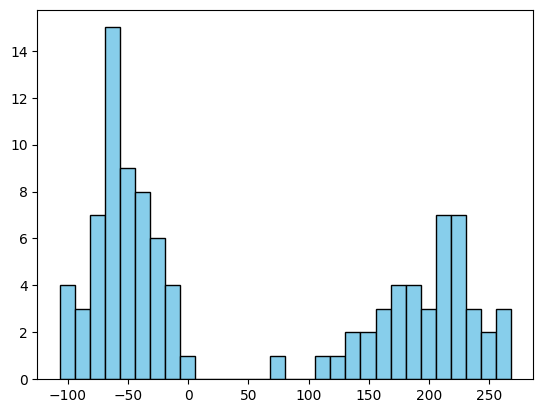

In [22]:
plt.hist(np.array(rewards).flatten(), bins=30, color='skyblue', edgecolor='black')
plt.show()

In [ ]:
rewards

AttributeError: 'list' object has no attribute 'var'

In [ ]:
torch.save(agent.pi.state_dict(), "./models/a2c_lunarlander.pth.pi")
torch.save(agent.v.state_dict(), "./models/a2c_lunarlander.pth.v")

In [ ]:
agent.load("./models/a2c_lunarlander.pth")

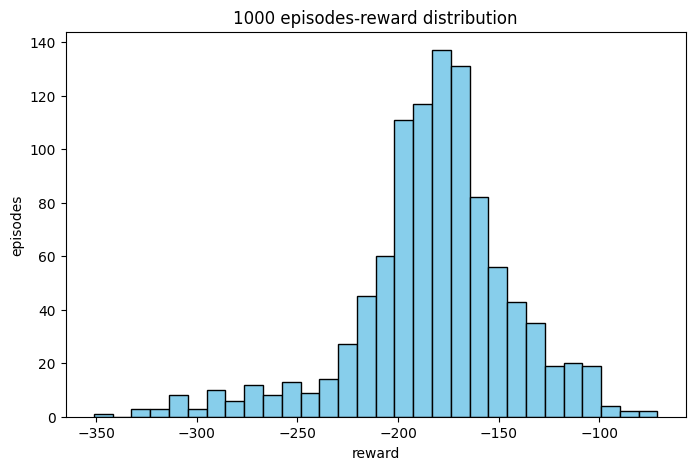

In [14]:
test_agent(agent)

In [8]:
save_video(agent, env,'a2c_lunarlander.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


NameError: name 'config' is not defined